### Assigment 4

**Submission deadlines**:

* get at least 4 points by 17.05.2023
* remaining points: last lab session before or on 26.05.2023

**Points:** Aim to get 12 out of 15+ possible points

All needed data files should be on Drive: <https://drive.google.com/drive/folders/1HaMbhzaBxxNa_z_QJXSDCbv5VddmhVVZ?usp=sharing> 

## Task 1 (5 points)

Implement simplified word2vec with negative sampling from scratch (using pure numpy). Assume that in the training data objects and contexts are given explicitly, one pair per line, and objects are on the left. The result of the training should be object vectors. Please, write them to a file using *natural* text format, ie

<pre>
word1 x1_1 x1_2 ... x1_N 
word2 x2_1 x2_2 ... x2_N
...
wordK xK_1 xK_2 ... xk_N
</pre>

Use the loss from Slide 25 in Lecture NLP.01, compute the gradient manually. You can use some gradient clipping, or regularisation. 

**Remark**: the data is specially prepared to make the learning process easier. 
Present vectors using the code below. In this task we define success as 'obtaining a result which looks definitely not random'


### Init

In [47]:
import numpy as np
import random

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from collections import Counter, defaultdict
from tqdm import tqdm
import gensim
import gzip
import re

## Ex. 1

In [32]:
class SlowoDwaWektor:
    
    def __init__(self):
        self.data = None
        self.embedding_size = 120
        self.LR = 0.005
        self.num_epochs = 4
        self.neg_samples = 15
        self.log_every = 2000
    
    def load_data(self, data_path):
        with open(data_path, 'r') as f:
            lines = f.readlines()
        self.data = []
        for line in lines:
            if random.random() < 0.01:
                self.data.append(line.strip().split())
        self.full_vocab = []
        self.full_vocab_unique = set()
        for p1,p2 in self.data:
            self.full_vocab.append(p1)
            if '_' in p2:
                self.full_vocab.append(p2.split('_')[1])
            else:
                self.full_vocab.append(p2)
        self.full_vocab_unique = list(set(self.full_vocab))
        print(f'[+] Loaded {len(self.data)} lines of words!')
    
    def loss(self, context_vector, target_vector, negative_vectors):
        pos_loss = -np.log(soft_max((target_vector@context_vector)))
        neg_loss = -np.sum(np.log(soft_max((negative_vectors@context_vector))))
        return pos_loss + neg_loss
    
    def get_negative_sample(self, target):
        sampled_indices = []
        while len(sampled_indices) < self.neg_samples:
            neg_words = random.choices(self.full_vocab_unique, k=self.embedding_size, weights=self.word_prob)
            if target not in neg_words:
                sampled_indices.extend([self.word_to_index[word] for word in neg_words])
        return np.array(sampled_indices)
    
    def train(self):
        self.word_to_index = {}
        self.index_to_word = {}
        vocab_size = len(self.full_vocab_unique)
        for i, word in enumerate(self.full_vocab_unique):
            self.word_to_index[word] = i
            self.index_to_word[i] = word

        # self.word_vectors = np.random.rand(vocab_size, self.embedding_size) # random initialization
        self.word_vectors = np.random.uniform(-1, 1, (vocab_size, self.embedding_size))

        for epoch in range(self.num_epochs):
            total_loss = 0.0
            itek = 0
            loss_tab = []
            for target_word, context_word in self.data:
                if '_' in context_word:
                    context_word = context_word.split('_')[1]
                target_index = self.word_to_index[target_word]
                context_index = self.word_to_index[context_word]
                negative_indices = self.get_negative_sample(target_word)

                target_vector = self.word_vectors[target_index]
                context_vector = self.word_vectors[context_index]
                negative_vectors = self.word_vectors[negative_indices]

                loss = self.loss(context_vector, target_vector, negative_vectors)
                loss_tab.append(loss)
                total_loss += loss

                self.word_vectors[target_index] -= self.LR * ((soft_max(context_vector@target_vector) - 1) * target_vector + (soft_max(negative_vectors@context_vector)[:,None] * negative_vectors).sum(0))
                self.word_vectors[context_index] -= self.LR * (soft_max(context_vector@target_vector) - 1) * context_vector
                self.word_vectors[negative_indices] -= self.LR * (soft_max(negative_vectors@context_vector)[:,None] * negative_vectors)
                if itek % self.log_every == 0:
                    print(f'avg_loss: {sum(loss_tab)/self.log_every}, total_loss: {total_loss}')
                    loss_tab = []
                itek += 1

            print(f"Epoch {epoch + 1}/{self.num_epochs}, Loss: {total_loss}")

    def save_to_file(self, path):
        with open(path, 'w') as f:
            for index, word in self.index_to_word.items():
                vector = self.word_vectors[index]
                vector_str = ' '.join([str(val) for val in vector])
                f.write(f"{word} {vector_str}\n")
    
    def filter_data(self, min_occurance=10):
        cnt = dict(Counter([word for word in self.full_vocab]))
        filtered_data = list(filter(lambda p: cnt[p[0]] >= min_occurance, self.data))
        self.cnt = cnt
        print(f'Old data size: {len(self.data)}\nNew data size: {len(filtered_data)}\nRemoving{100 * (len(self.data)-len(filtered_data))/(len(self.data)):.2f}%')
        old_size = len(self.data)
        self.data = filtered_data
        self.word_prob = [(self.cnt[w]**0.75)/old_size for w in self.full_vocab_unique]
        

In [33]:
def soft_max(x):
    return 1/(1 + np.exp(-x))

In [34]:
w2v = SlowoDwaWektor()
w2v.load_data('data/task1_objects_contexts_polish.txt')
w2v.filter_data(3)
w2v.train()

[+] Loaded 55287 lines of words!
Old data size: 55287
New data size: 46743
Removing15.45%
avg_loss: 0.09509479388520288, total_loss: 190.18958777040575
avg_loss: 189.4950125567164, total_loss: 379180.21470120316
avg_loss: 175.78579240942202, total_loss: 730751.7995200459
avg_loss: 164.82686127708274, total_loss: 1060405.5220742123
avg_loss: 154.8455858189068, total_loss: 1370096.6937120275
avg_loss: 146.45743218779853, total_loss: 1663011.5580876258
avg_loss: 139.32458014934943, total_loss: 1941660.718386326
avg_loss: 133.5475392099728, total_loss: 2208755.796806275
avg_loss: 127.51892286598394, total_loss: 2463793.6425382574
avg_loss: 123.31115868492317, total_loss: 2710415.959908099
avg_loss: 119.68191087008374, total_loss: 2949779.781648273
avg_loss: 115.99737608670561, total_loss: 3181774.5338216843
avg_loss: 113.42923075021359, total_loss: 3408632.995322113
avg_loss: 110.91079541478517, total_loss: 3630454.586151679
avg_loss: 107.92298852057212, total_loss: 3846300.563192824
avg_l

In [39]:
w2v.save_to_file('task1_w2v_vectors.txt')

In [36]:
suma = 0
dupa=0
visited = set()
for w in w2v.cnt:
    if w2v.cnt[w] > 3500:
        assert w not in visited
        visited.add(w)
        suma += w2v.cnt[w]
        dupa += 1
print(dupa,'\n',suma)

0 
 0


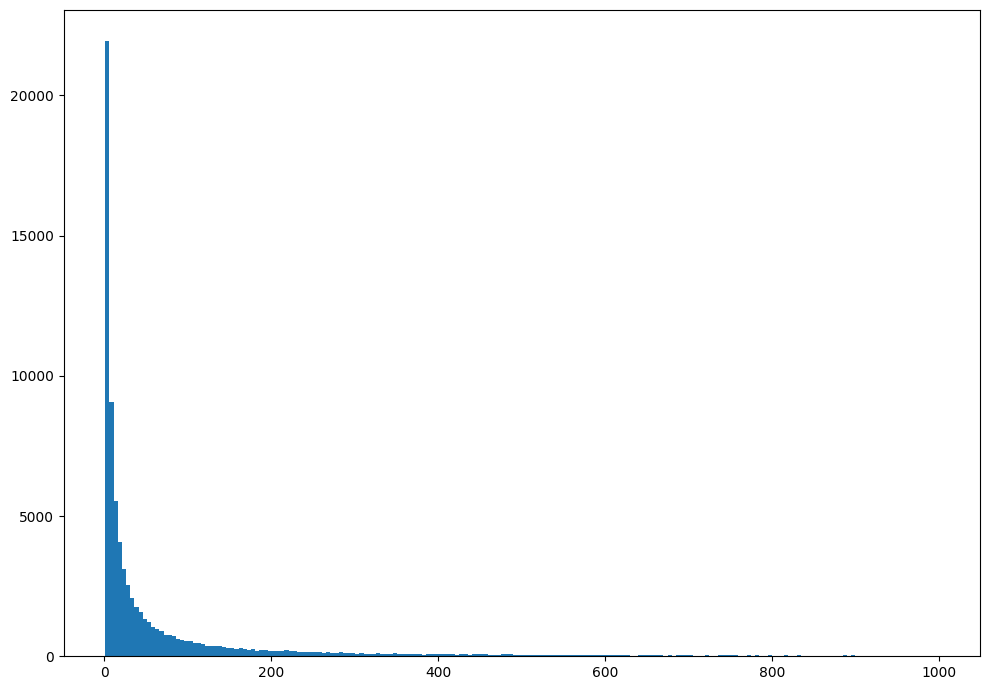

In [75]:
occ = list(w2v.cnt.values())
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
occ = np.array(occ)
occ = occ[occ < 1000]
axs.hist(occ, bins = 200)
plt.show()

In [42]:
from gensim.models import KeyedVectors
task1_wv = KeyedVectors.load_word2vec_format('task1_w2v_vectors.txt', binary=False)

example_english_words = ['dog', 'dragon', 'love', 'bicycle', 'marathon', 'logic', 'butterfly']  # replace, or add your own examples
example_polish_words = ['pies', 'smok', 'miłość', 'rower', 'maraton', 'logika', 'motyl']

example_words = example_polish_words

for w0 in example_words:
    print ('WORD:', w0)
    for w, v in task1_wv.most_similar(w0):
        print ('   ', w, v)
    print ()

WORD: pies
    mejoza 0.35160526633262634
    przylot 0.35017895698547363
    odwijać 0.3482518196105957
    spazm 0.34482863545417786
    zbliżać 0.3392108976840973
    zastępczy 0.31202584505081177
    żer 0.30797553062438965
    zawrzeć 0.3032503128051758
    złagodzenie 0.2995203733444214
    samobadanie 0.29350408911705017

WORD: smok
    laleczka 0.3946513533592224
    audyt 0.33622029423713684
    przyklejać 0.3262861967086792
    kręty 0.32525166869163513
    spartakiada 0.3160785138607025
    konstancja 0.3153826594352722
    presupozycja 0.3103264272212982
    teledysk 0.3102502226829529
    richard 0.3047626316547394
    trudniejszy 0.30339276790618896

WORD: miłość
    odrętwienie 0.40408554673194885
    marka 0.35120901465415955
    łagier 0.34148383140563965
    bujny 0.33595356345176697
    obcować 0.33426111936569214
    wyświetlenie 0.33228573203086853
    głup 0.3193388283252716
    zwalnianie 0.30999845266342163
    klara 0.3097013831138611
    transza 0.308798283338

In [45]:
task1_wv.similarity('kobieta', 'mężczyzna')
for w, v in task1_wv.most_similar('mężczyzna'):
    print ('   ', w, v)
print ()

    sahara 0.33845117688179016
    konstytucjonalizm 0.3321194350719452
    mysz 0.327793687582016
    przepakować 0.32736051082611084
    rozwaga 0.3054957687854767
    świerczewski 0.3023218512535095
    wyeliminowanie 0.2995588183403015
    zwarty 0.2988737225532532
    jabłonna 0.29872727394104004
    awans 0.29787787795066833



## Task 2 (4 points)

Your task is to train the embeddings for Simple Wikipedia titles, using gensim library. As the example below shows, training is really simple:

```python
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")
```
*sentences* can be a list of list of tokens, you can also use *gensim.models.word2vec.LineSentence(source)* to create restartable iterator from file. At first, use [this file] containing such pairs of titles, that one article links to another.

We say that two titles are *related* if they both contain a word (or a word bigram) which is not very popular (it occurs only in several titles). Make this definition more precise, and create the corpora which contains pairs of related titles. Make a mixture of the original corpora, and the new one, then train title vectors again.

Compare these two approaches using similar code to the code from Task 1.

## Ex. 2

In [18]:
class WikiLink:
    """An iterator that yields sentences (lists of str)."""
    def __init__(self, path = "data/task2_simple.wiki.links.txt.gz"):
        self.path = path
    
    def __iter__(self):
        with gzip.open(self.path, 'rt') as f:
            for line in f:
                yield line.strip().split()
                
wiki_corpora = WikiLink()

In [19]:
model = Word2Vec(
    sentences=wiki_corpora, 
    vector_size=100, 
    window=5, 
    min_count=1, 
    workers=4
)
model.save("word2vec_wiki.model")

In [48]:
model = gensim.models.Word2Vec.load("word2vec_wiki.model")

In [25]:
word_freq = defaultdict(int)
wiki_corpora_size = 0

for title in tqdm(wiki_corpora):
    wiki_corpora_size += 1
    for word in title:
        word_freq[word] += 1

7571390it [00:15, 497649.65it/s]


In [39]:
threshold = 500
related_wiki_corpora = []

for title_pair in tqdm(wiki_corpora, total=wiki_corpora_size):
    if len(title_pair) == 2:
        t1 = re.split(r'_|:|\\|\/|-', title_pair[0])
        t2 = re.split(r'_|:|\\|\/|-', title_pair[1])
        t1 = [w for w in t1 if len(w) > 0]
        t2 = [w for w in t2 if len(w) > 0]
        if any(word_freq[word] < threshold for word in set(t1).intersection(t2)):
            related_wiki_corpora.append(t1 + t2)

100%|█████████████████████████████| 7571390/7571390 [00:36<00:00, 209305.24it/s]


In [42]:
len(related_wiki_corpora) / wiki_corpora_size

0.11820286631648878

In [45]:
model = Word2Vec(
    sentences=related_wiki_corpora, 
    vector_size=100, 
    window=5, 
    min_count=1, 
    workers=4
)
model.save("word2vec_wiki_related.model")

In [49]:
model_related = gensim.models.Word2Vec.load("word2vec_wiki_related.model")

In [53]:
example_words = ["france", "canada", "actor", 
                 "war", "animal", "lion", "angle"]

for w0 in example_words:
    print (f'OG model: [{w0}]')
    for w, v in model.wv.most_similar(w0):
        print ('   ', w, v)
    print(f"RELATED model[{w0}]:")   
    for w, v in model_related.wv.most_similar(w0):
        print ('   ', w, v)
    print ()

OG model: [france]
    communes_of_france 0.929648756980896
    departments_of_france 0.926301896572113
    regions_of_france 0.9084035754203796
    paris 0.8786289691925049
    pays_de_la_loire 0.850056529045105
    commune_in_france 0.8354650735855103
    brittany 0.8287339210510254
    nord-pas-de-calais 0.8194249272346497
    template:pas-de-calais_communes 0.8097964525222778
    somme 0.8059446811676025
RELATED model[france]:
    french 0.7099596261978149
    belgium 0.6925283074378967
    italy 0.6833450794219971
    sweden 0.6565394997596741
    england 0.6536797285079956
    europe 0.6512018442153931
    romania 0.627118706703186
    paris 0.6097730398178101
    switzerland 0.6019037961959839
    spain 0.6005282402038574

OG model: [canada]
    british_columbia 0.8625205755233765
    toronto 0.8618823885917664
    ontario 0.8454139232635498
    quebec 0.8440713286399841
    vancouver 0.8372489213943481
    usa 0.8226689696311951
    coast_mountains 0.8152483701705933
    montre

# Task 3 (4 points)

Suppose that we have two languages: Upper and Lower. This is an example Upper sentence:

<pre>
THE QUICK BROWN FOX JUMPS OVER THE LAZY DOG.
</pre>

And this is its translation into Lower:

<pre>
the quick brown fox jumps over the lazy dog
</pre>

You have two corpora for these languages (with different sentences). Your task is to train word embedings for both languages together, so as to make embeddings of the words which are its translations as close as possible. But unfortunately, you have the budget which allows you to prepare the translation only for 1000 words (we call it D, you have to deside which words you want to be in D)

Prepare the corpora wich contains three kind of sentences:
* Upper corpus sentences
* Lower corpus sentences
* sentences derived from Upper/Lower corpus, modified using D

There are many possible ways of doing this, for instance this one (ROT13.COM: hfr rirel fragrapr sebz obgu pbecben gjvpr: jvgubhg nal zbqvsvpngvbaf, naq jvgu rirel jbeqf sebz Q ercynprq ol vgf genafyngvba)

We define the score for an Upper WORD as  $\frac{1}{p}$, where $p$ is a position of its translation in the list of **Lower** words most similar to WORD. For instance, when most similar words to DOG are:

<pre>
WOLF, CAT, WOLVES, LION, gopher, dog
</pre>

then the score for the word DOG is 0.5. Compute the average score separately for words from D, and for words out of D (hint: if the computation takes to much time do it for a random sample).


## Ex. 3

In [54]:
from gensim.models import Word2Vec
import random

In [100]:
class Corpora:
    """An iterator that yields sentences (lists of str)."""
    def __init__(self, path):
        self.path = path
    
    def __iter__(self):
        with gzip.open(self.path, 'rt') as f:
            for line in f:
                yield line.strip().split()
            
lower_corpus = list(Corpora("data/task3_polish_lower.txt.gz"))
upper_corpus = list(Corpora("data/task3_polish_upper.txt.gz"))

In [101]:
full_vocab_up = set()
full_vocab_low = set()

for s in lower_corpus:
    for w in s:
        if len(w) > 2:
            full_vocab_low.add(w.lower())

for s in upper_corpus:
    for w in s:
        if len(w) > 2:
            full_vocab_up.add(w.lower())
            
common_vocab = full_vocab_up.intersection(full_vocab_low)

In [102]:
random_words = random.sample(common_vocab, k=1000)

low2up = {w.lower(): w.upper() for w in random_words}
up2low = {w.upper(): w.lower() for w in random_words}

out_words = [w for w in common_vocab if w not in random_words]
random_out_words = random.sample(out_words, k=10000)

# Modify Upper/Lower corpus using D
def modify_corpus(corpus, D):
    return [[D[word] if word in D else word for word in sentence] for sentence in corpus]

upper_corpus_modified = modify_corpus(upper_corpus, up2low)
lower_corpus_modified = modify_corpus(lower_corpus, low2up)

# Combine corpora for joint training
combined_corpus = upper_corpus + lower_corpus + upper_corpus_modified + lower_corpus_modified

/tmp/ipykernel_97534/1819341793.py:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_words = random.sample(common_vocab, k=1000)


In [104]:
model = Word2Vec(sentences=combined_corpus, vector_size=100, window=5, min_count=1, workers=4)
model.save('word2vec_uplow.model')

In [96]:
model = gensim.models.Word2Vec.load("word2vec_wiki.model")

In [105]:
# Compute scores for each word
def compute_score(word):
    similar_words = model.wv.most_similar(word)
    similar_words = [w for w, _ in similar_words]
    if word.lower() in similar_words:
        return 1 / (similar_words.index(word.lower()) + 1)
    else:
        return 0
random_out_words = random.sample(out_words, k=10000)

# Compute average scores separately for words from D and for words out of D
in_d_scores = [compute_score(word.upper()) for word in random_words]
out_of_d_scores = [compute_score(word.upper()) for word in random_out_words]

non_zero_in = 0
for score in in_d_scores:
    if score:
        non_zero_in+=1
non_zero_out = 0
for score in out_of_d_scores:
    if score:
        non_zero_out+=1

print(f"Average score for words in D: {sum(in_d_scores) / non_zero_in}")
print(f"Average score for words out of D: {sum(out_of_d_scores) / non_zero_out}")

Average score for words in D: 0.9964001384562133
Average score for words out of D: 0.2921319102353585


# Task 4 (4 points)

In this task you are asked to do two things:
1. compare the embeddings computed on small corpus (like Brown Corpus , see: <https://en.wikipedia.org/wiki/Brown_Corpus>) with the ones coming from Google News Corpus
2. Try to use other resourses like WordNet to enrich to corpus, and obtain better embeddings

You can use the following code snippets:

```python
# printing tokenized Brown Corpora
from nltk.corpus import brown
for s in brown.sents():
    print(*s)
    
#iterating over all synsets in WordNet
from nltk.corpus import wordnet as wn

for synset_type in 'avrns': # n == noun, v == verb, ...
    for synset in list(wn.all_synsets(synset_type)))[:10]:
        print (synset.definition())
        print (synset.examples())
        print ([lem.name() for lem in synset.lemmas()])
        print (synset.hyperonims()) # nodes 1 level up in ontology
        
# loading model and compute cosine similarity between words

model = Word2Vec.load('models/w2v.wordnet5.model') 
print (model.wv.similarity('dog', 'cat'))
```

Embeddings will be tested using WordSim-353 dataset, the code showing the quality is in the cell below. Prepare the following corpora:
1. Tokenized Brown Corpora
2. Definitions and examples from Princeton WordNet
3. (1) and (2) together
4. (3) enriched with pseudosentences containing (a subset) of WordNet knowledge (such as 'tiger is a carnivore')

Train 4 Word2Vec models, and raport Spearman correletion between similarities based on your vectors, and similarities based on human judgements.



## Ex. 4

In [2]:
import nltk

nltk.download('brown')
nltk.download('wordnet')

from nltk.corpus import brown
from nltk.corpus import wordnet as wn

from gensim.test.utils import datapath
from gensim.models import Word2Vec

from scipy.stats import spearmanr

[nltk_data] Downloading package brown to /home/maurycy/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to /home/maurycy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
brown_corpus = list(brown.sents())

wordnet_corpus = []
for synset_type in 'avrns':
    for synset in list(wn.all_synsets(synset_type)):
        definition = synset.definition().split()
        wordnet_corpus.append(definition)
        for example in synset.examples():
            wordnet_corpus.append(example.split())

combined_corpus = brown_corpus + wordnet_corpus

enriched_corpus = combined_corpus.copy()
for synset in list(wn.all_synsets()):
    pseudosentence = synset.hypernym_paths()[0]
    pseudosentence = [lemma.name() for syn in pseudosentence for lemma in syn.lemmas()]
    enriched_corpus.append(pseudosentence)

In [10]:
models = []
for corpus in [brown_corpus, wordnet_corpus, combined_corpus, enriched_corpus]:
    print(f'len(corpus)={len(corpus)}')
    model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4)
    models.append(model)

len(corpus)=57340
len(corpus)=189288
len(corpus)=246628
len(corpus)=364287


In [13]:
banned = set()

with open(datapath("wordsim353.tsv")) as file:
    for line in file:
        if line[0] != '#':
            word1, word2, score = line.strip().split('\t')
            for model in models:
                try:
                    model.wv.similarity(word1, word2)
                except KeyError:
                    banned.add((word1, word2))

In [14]:
# Load WordSim-353 dataset and calculate similarities

similarity = [[], [], [], []]
human = []

with open(datapath("wordsim353.tsv")) as file:
    for line in file:
        if line[0] != '#':
            word1, word2, score = line.strip().split('\t')
            if (word1, word2) not in banned:
                score = float(score)
                human.append(score)
                similarities = []
                for i, model in enumerate(models):
                        similarity[i].append(model.wv.similarity(word1, word2))

# Calculate Spearman correlation between model similarities and human judgments
correlations, pvals = [], []
for i in range(4):
    correlation, pval = spearmanr(similarity[i], human)
    correlations.append(correlation)
    pvals.append(pval)

print("Spearman Correlation and pvals:")
print(f"Brown Corpus:          {correlations[0]}, pval: {pvals[0]}")
print(f"WordNet Corpus:    {correlations[1]}, pval: {pvals[1]}")
print(f"Combined Corpus:       {correlations[2]}, pval: {pvals[2]}")
print(f"Enriched Corpus:       {correlations[3]}, pval: {pvals[3]}")

Spearman Correlation and pvals:
Brown Corpus:          -0.003833532598177231, pval: 0.9459701464722843
WordNet Corpus:    0.23826020839468162, pval: 1.9234973267081473e-05
Combined Corpus:       0.3172703912315073, pval: 8.509300936622935e-09
Enriched Corpus:       0.3960375408291786, pval: 2.8406363593103117e-13


# Task 5 (4 points)

Do the Problem 1 from old version of [Assigment 4](https://github.com/rnoxy/dl_uwr/blob/summer2023/Assignments/Assignment4.ipynb)